# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given plant is Healthy or Powdery or Rust.


## Inputs

* inputs/plants_dataset/train
* inputs/plants_dataset/test
* inputs/plants_dataset/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd= os.getcwd()
print(cwd)

/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks


In [3]:
os.chdir('/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks')
print("You set a new current directory")

You set a new current directory


In [4]:

work_dir = os.getcwd()
work_dir

'/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks'

---

## Set input directories

Set train, validation and test paths

In [113]:
my_data_dir = '../inputs/plants_dataset'
train_path = my_data_dir + '/Train'
val_path = my_data_dir + '/Validation'
test_path = my_data_dir + '/Test'

## Set output directory

In [114]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [115]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['Healthy', 'Powdery', 'Rust']


## Set image shape

In [116]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(173, 256, 3)

---

# Number of images in train, test and validation data

* Train - Healthy: 458 images
* Train - Powdery: 430 images
* Train - Rust: 434 images
* Validation - Healthy: 20 images
* Validation - Powdery: 20 images
* Validation - Rust: 20 images
* Test - Healthy: 50 images
* Test - Powdery: 50 images
* Test - Rust: 50 images




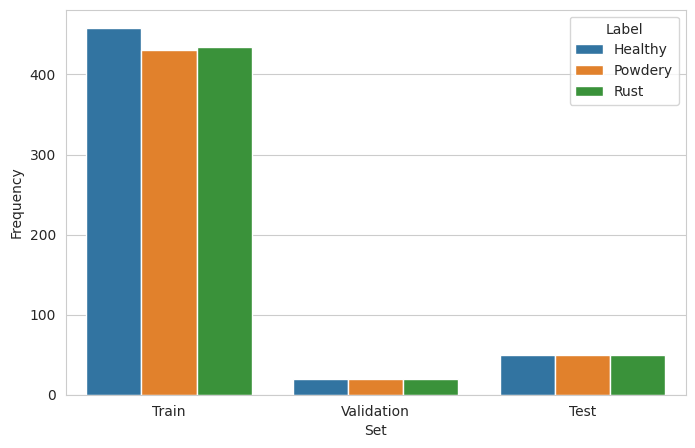

In [117]:
df_freq = pd.DataFrame([])
for folder in ['Train', 'Validation', 'Test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

---

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [118]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [119]:
batch_size =  20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 1322 images belonging to 3 classes.


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

* ### Augment validation image dataset

In [120]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 60 images belonging to 3 classes.


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

* ### Augment test image dataset

In [121]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 150 images belonging to 3 classes.


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

## Plot augmented training image

(20, 173, 256, 3)


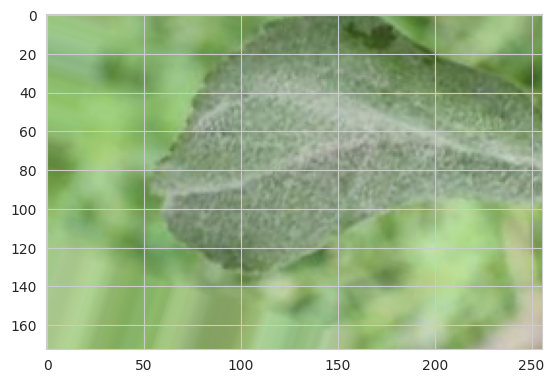

(20, 173, 256, 3)


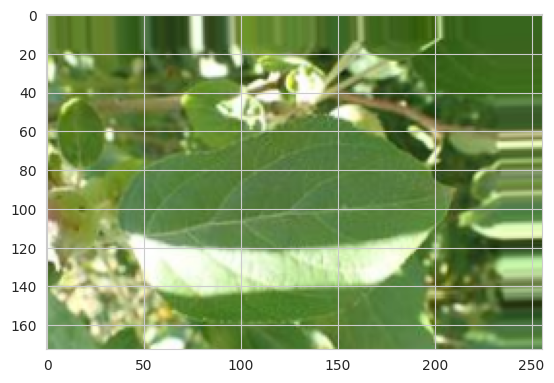

(20, 173, 256, 3)


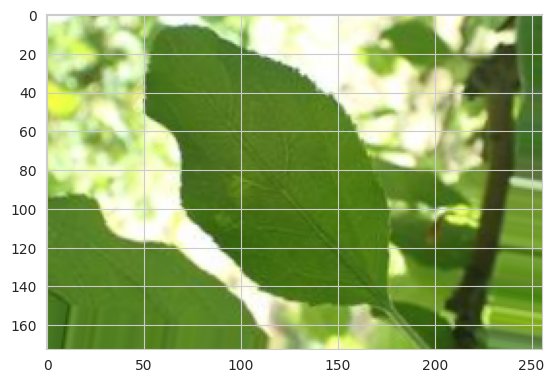

In [122]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 173, 256, 3)


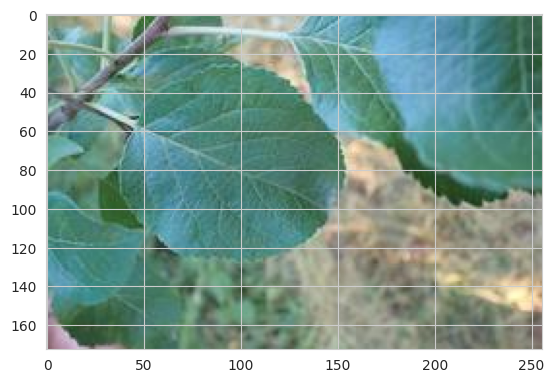

(20, 173, 256, 3)


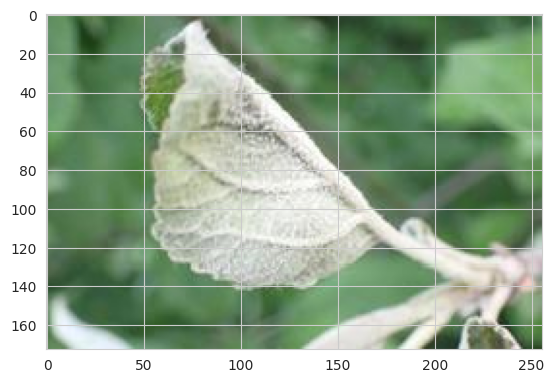

(20, 173, 256, 3)


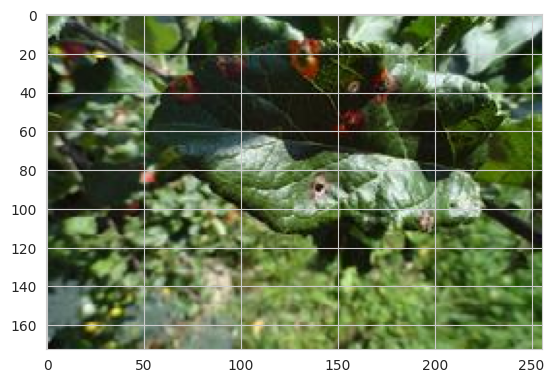

In [123]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 173, 256, 3)


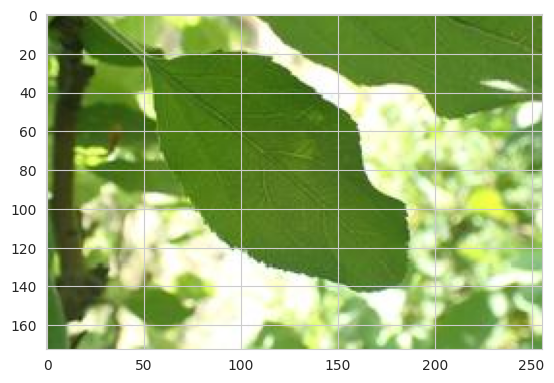

(20, 173, 256, 3)


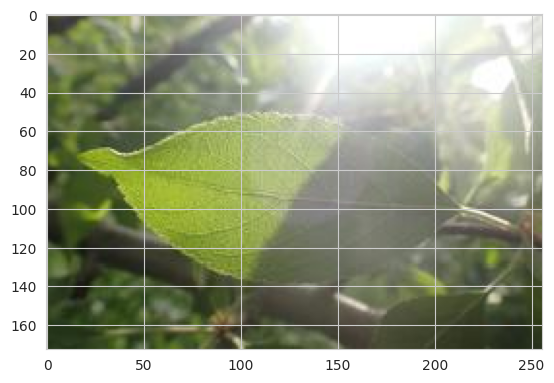

(20, 173, 256, 3)


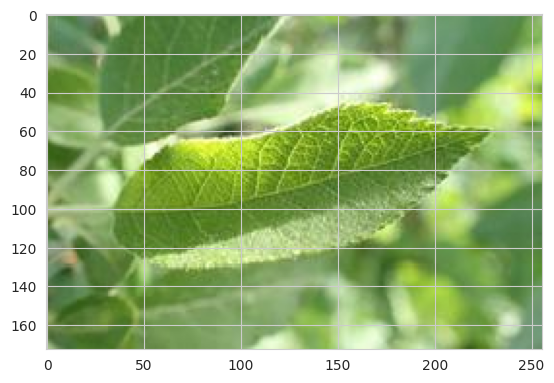

In [64]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [124]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [125]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    

    return model


* ### Model Summary 

In [126]:
create_tf_model().summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 171, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 85, 127, 64)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 83, 125, 64)       36928     
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 41, 62, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 39, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 19, 30, 128)       0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 72960)           

* ### Early Stopping 

In [109]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [127]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/25
66/66 [==============================] - 51s 682ms/step - loss: 1.0104 - accuracy: 0.3272 - val_loss: -3.0276 - val_accuracy: 0.3333
Epoch 2/25
66/66 [==============================] - 39s 582ms/step - loss: 32.1876 - accuracy: 0.3264 - val_loss: 130.7021 - val_accuracy: 0.3333
Epoch 3/25
66/66 [==============================] - 43s 651ms/step - loss: -305.9608 - accuracy: 0.3310 - val_loss: -1367.2291 - val_accuracy: 0.3333
Epoch 4/25
66/66 [==============================] - 43s 637ms/step - loss: -5767.7920 - accuracy: 0.3218 - val_loss: -21597.5371 - val_accuracy: 0.3333
Epoch 5/25
66/66 [==============================] - 38s 566ms/step - loss: -33993.6328 - accuracy: 0.3372 - val_loss: -85416.8672 - val_accuracy: 0.3333
Epoch 6/25
66/66 [==============================] - 38s 588ms/step - loss: -375759.7812 - accuracy: 0.3233 - val_loss: -383048.5312 - val_accuracy: 0.3333
Epoch 7/25
66/66 [==============================] - 38s 575ms/step - loss: -1018392.3750 - accuracy:

## Save model

In [128]:
model.save('outputs/v1/plant_disease_detector.h5')

---

# Model Performace

---

## Model learning curve

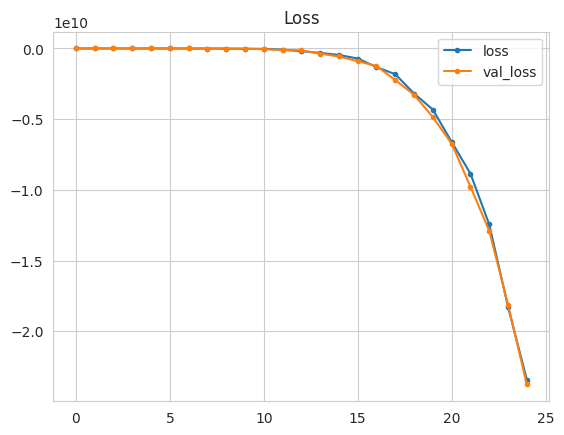

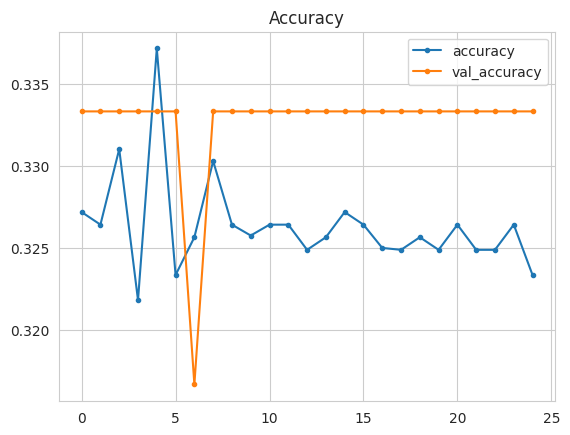

In [129]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [130]:
from keras.models import load_model
model = load_model('outputs/v1/plant_disease_detector.h5')

Evaluate model on test set

In [131]:
evaluation = model.evaluate(test_set)


8/8 [==============================] - 2s 176ms/step - loss: -24575696896.0000 - accuracy: 0.3333


### Save evaluation pickle

In [132]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (256, 173), Image mode: RGB


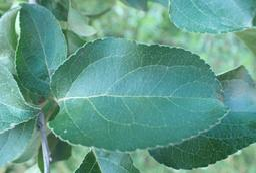

In [146]:
from tensorflow.keras.preprocessing import image

pointer = 41
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [143]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 173, 256, 3)


Predict class probabilities

In [144]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1.0
Powdery


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [33]:
!cat .gitignore

inputs/malaria_dataset/cell_images/test
inputs/malaria_dataset/cell_images/train
kaggle.json
*.ipynb
__pycache__/



* Git status

In [34]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb
	modified:   outputs/v1/malaria_detector_model.h5
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v1/evaluation.pkl

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [ ]:
!git add .

* Git commit

In [ ]:
!git commit -am " Add new plots"

* Git Push

In [ ]:
!git push

---